In [1]:
#Mounting the Google Drive to the Colab
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
%mkdir -p /root/AnalyticsVidhya
!ln -s /content/gdrive/My\ Drive/AnalyticsVidhya/3_Customer_Segmentation/ /root/AnalyticsVidhya

#Navigate to the Directory
%cd /root/AnalyticsVidhya/3_Customer_Segmentation/
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/AnalyticsVidhya/3_Customer_Segmentation
sample_submission_wyi0h0z.csv  submission_1596289179.csv
submission_1596285471.csv      submission_1596289604.csv
submission_1596287302.csv      submission_1596299705.csv
submission_1596287603.csv      submission_1596300287.csv
submission_1596287885.csv      submission_1596300515.csv
submission_1596288514.csv      Test_LqhgPWU.csv
submission_1596288984.csv      Train_aBjfeNk.csv


In [2]:
#Import Libraries
#----------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import time,re
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve
from sklearn.linear_model import LogisticRegression

%matplotlib inline
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [226]:
#Load Dataset
#------------
train=pd.read_csv('Train_aBjfeNk.csv')
test=pd.read_csv('Test_LqhgPWU.csv')

train_orig=train.copy()
test_orig=test.copy()

#Train Dataset Analysis
#----------------------
print("Train Shape : ",train.shape)
print("Test Shape : ",test.shape)
print()

print("Train Columns")
print("----- -------")
print(train.columns)
print()

print("Train Datatypes")
print("----- ---------")
print(train.dtypes)
print()

print("Train Details")
print("----- -------")
train.describe()

#Merging Test data with Training
#------- ---- ---- ---- --------
#Creating Segmentation Column for the Test Data
test_with_Segmentation=test.copy()
test_with_Segmentation['Segmentation']=''

#Creating a Dictionary of Train Data with IDs as Keys and Segmentations as Values
mapped_dict={}
for index, row in train.iterrows():
    mapped_dict.update({row['ID'] : row['Segmentation']})

#Copying the Segmentation values into Test Data from Train Data if Test ID matches the Train ID
new_rows=[]
for index,row in test_with_Segmentation.iterrows():
  test_with_Segmentation['Segmentation'][index]=mapped_dict.get(test_with_Segmentation['ID'][index])

#Removing the Test Dataframe rows that doesn't matches with Train IDs
options=['A','B','C','D']
test_with_Segmentation=test_with_Segmentation[test_with_Segmentation['Segmentation'].isin(options)]

print(test_with_Segmentation.shape)
#Merge Train Data with Processed Test Data
#train=pd.concat((train,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation),ignore_index=True)
train=pd.concat((train,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation,test_with_Segmentation),ignore_index=True)

#Train Dataset Analysis
#----------------------
print("Train Shape : ",train.shape)
print("Test Shape : ",test.shape)
print()

print("Train Columns")
print("----- -------")
print(train.columns)
print()

print("Train Datatypes")
print("----- ---------")
print(train.dtypes)
print()

print("Train Details")
print("----- -------")
train.describe()
train.tail(50)

Train Shape :  (8068, 11)
Test Shape :  (2627, 10)

Train Columns
----- -------
Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

Train Datatypes
----- ---------
ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

Train Details
----- -------
(2332, 11)
Train Shape :  (26724, 11)
Test Shape :  (2627, 10)

Train Columns
----- -------
Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

Train Datatypes
----- ---------
ID                   int64
Gender              o

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
26674,467772,Female,No,31,No,Marketing,0.0,Low,2.0,Cat_6,D
26675,467779,Male,Yes,52,Yes,Doctor,4.0,Average,3.0,Cat_6,C
26676,467798,Female,No,23,No,NaN,NaN,Low,2.0,Cat_6,D
26677,467802,Female,Yes,48,Yes,Artist,1.0,High,5.0,Cat_6,C
26678,467803,Female,Yes,40,Yes,Entertainment,6.0,Average,2.0,Cat_6,B
26679,467806,Male,Yes,55,Yes,Artist,1.0,High,2.0,Cat_6,B
26680,467808,Female,Yes,62,Yes,Artist,1.0,Average,2.0,Cat_6,C
26681,467812,Male,No,48,Yes,Artist,0.0,Low,1.0,Cat_2,B
26682,467813,Male,Yes,36,Yes,Entertainment,1.0,Low,2.0,Cat_4,A
26683,467815,Female,Yes,73,Yes,Artist,0.0,Low,2.0,Cat_6,C


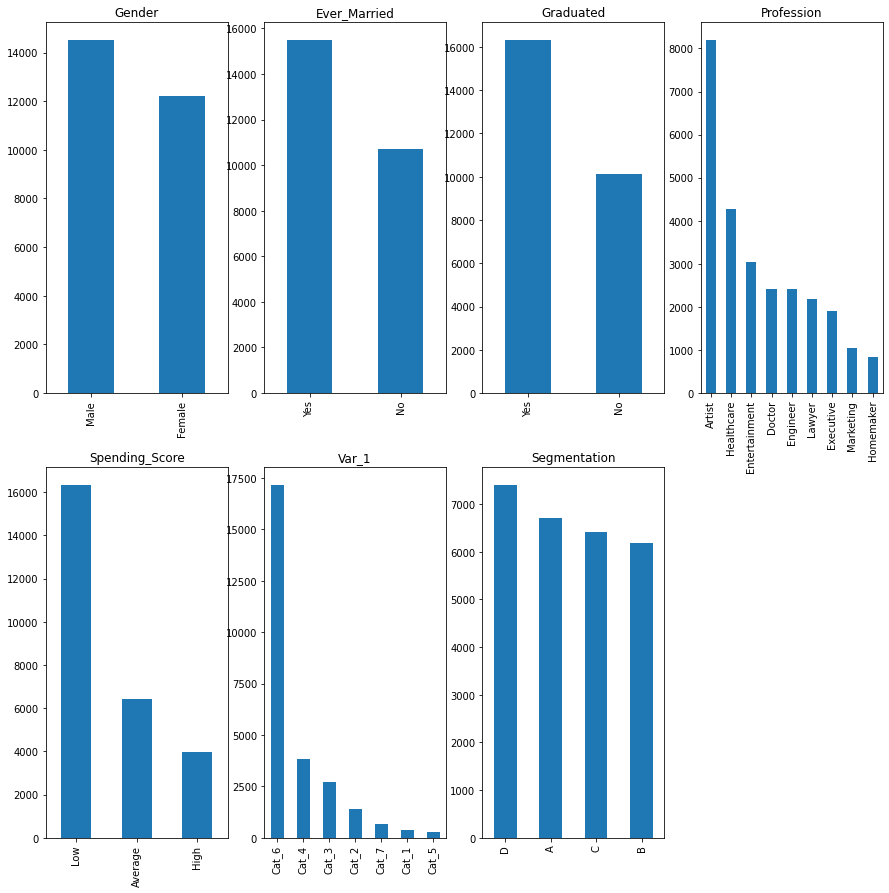

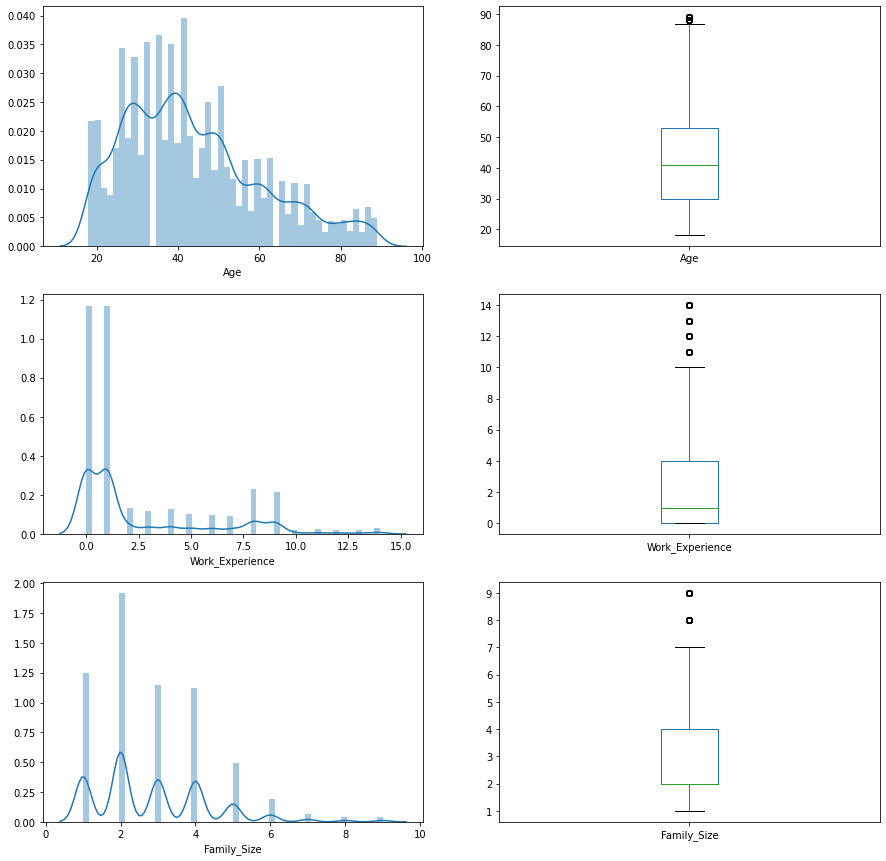

In [227]:
#Univariate Analysis
#---------- --------
#Categorical Variables
plt.figure(1)

plt.subplot(241)
train['Gender'].value_counts().plot.bar(figsize=(15,15),title="Gender")

plt.subplot(242)
train['Ever_Married'].value_counts().plot.bar(figsize=(15,15),title="Ever_Married")

plt.subplot(243)
train['Graduated'].value_counts().plot.bar(figsize=(15,15),title="Graduated")

plt.subplot(244)
train['Profession'].value_counts().plot.bar(figsize=(15,15),title="Profession")

plt.subplot(245)
train['Spending_Score'].value_counts().plot.bar(figsize=(15,15),title="Spending_Score")

plt.subplot(246)
train['Var_1'].value_counts().plot.bar(figsize=(15,15),title="Var_1")

plt.subplot(247)
train['Segmentation'].value_counts().plot.bar(figsize=(15,15),title="Segmentation")

#Numerical Variables
plt.figure(2)

plt.subplot(321)
sns.distplot(train['Age'])
plt.subplot(322)
train['Age'].plot.box(figsize=(15,15))

plt.subplot(323)
sns.distplot(train['Work_Experience'])
plt.subplot(324)
train['Work_Experience'].plot.box(figsize=(15,15))

plt.subplot(325)
sns.distplot(train['Family_Size'])
plt.subplot(326)
train['Family_Size'].plot.box(figsize=(15,15))


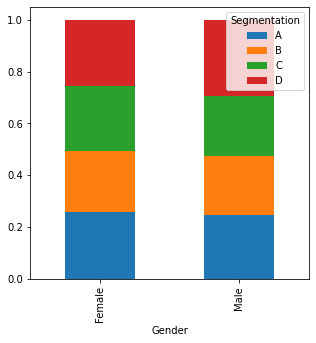

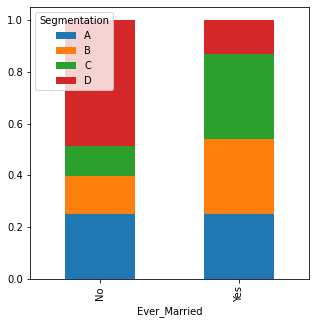

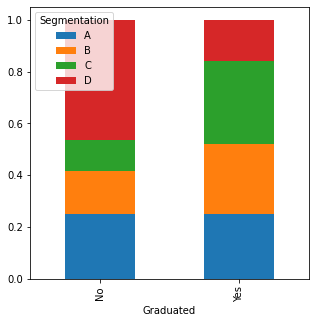

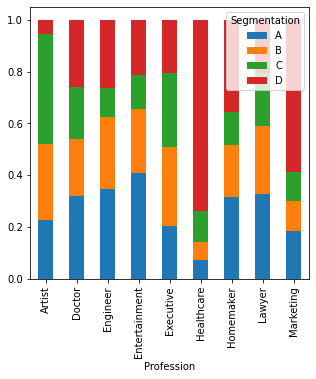

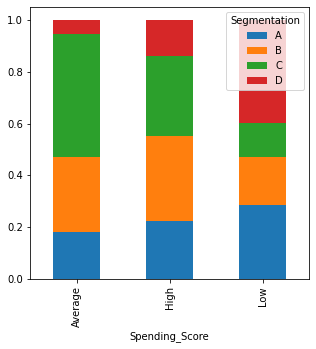

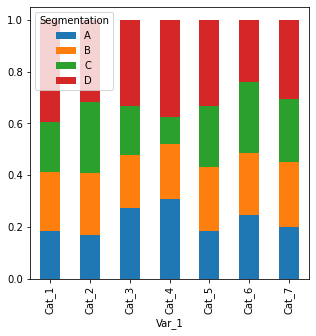

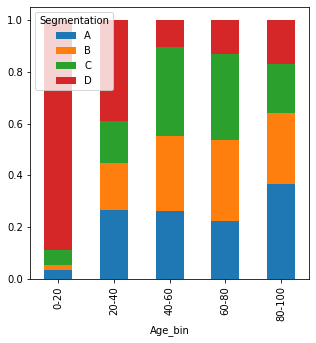

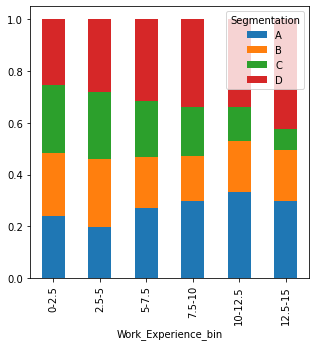

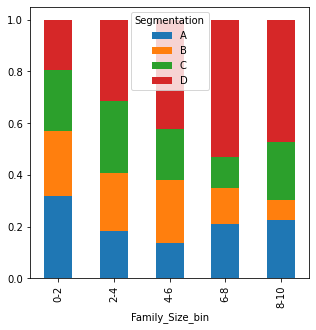

In [228]:
#Bivariate Analysis
#--------- --------

#Categorical Variables
Gender=pd.crosstab(train['Gender'],train['Segmentation'])
Gender.div(Gender.sum(1),axis=0).plot.bar(stacked=True,figsize=(5,5))

Ever_Married=pd.crosstab(train['Ever_Married'],train['Segmentation'])
Ever_Married.div(Ever_Married.sum(1),axis=0).plot.bar(stacked=True,figsize=(5,5))

Graduated=pd.crosstab(train['Graduated'],train['Segmentation'])
Graduated.div(Graduated.sum(1),axis=0).plot.bar(stacked=True,figsize=(5,5))

Profession=pd.crosstab(train['Profession'],train['Segmentation'])
Profession.div(Profession.sum(1),axis=0).plot.bar(stacked=True,figsize=(5,5))

Spending_Score=pd.crosstab(train['Spending_Score'],train['Segmentation'])
Spending_Score.div(Spending_Score.sum(1),axis=0).plot.bar(stacked=True,figsize=(5,5))

Var_1=pd.crosstab(train['Var_1'],train['Segmentation'])
Var_1.div(Var_1.sum(1),axis=0).plot.bar(stacked=True,figsize=(5,5))


#Numerical Variables
bins=[0,20,40,60,80,100] 
group=['0-20','20-40','40-60', '60-80', '80-100'] 
train['Age_bin']=pd.cut(train['Age'],bins=bins,labels=group)
Age_bin=pd.crosstab(train['Age_bin'],train['Segmentation'])
Age_bin.div(Age_bin.sum(1), axis=0).plot.bar(stacked=True,figsize=(5,5))

bins=[0,2.5,5,7.5,10,12.5,15] 
group=['0-2.5','2.5-5','5-7.5','7.5-10','10-12.5','12.5-15'] 
train['Work_Experience_bin']=pd.cut(train['Work_Experience'],bins=bins,labels=group)
Work_Experience_bin=pd.crosstab(train['Work_Experience_bin'],train['Segmentation'])
Work_Experience_bin.div(Work_Experience_bin.sum(1), axis=0).plot.bar(stacked=True,figsize=(5,5))

bins=[0,2,4,6,8,10] 
group=['0-2','2-4','4-6', '6-8', '8-10'] 
train['Family_Size_bin']=pd.cut(train['Family_Size'],bins=bins,labels=group)
Family_Size_bin=pd.crosstab(train['Family_Size_bin'],train['Segmentation'])
Family_Size_bin.div(Family_Size_bin.sum(1), axis=0).plot.bar(stacked=True,figsize=(5,5))


In [229]:
#Remove unnecessary bins
#------ ----------- ----
try:
    train=train.drop(['Age_bin','Work_Experience_bin','Family_Size_bin'],axis=1)
    print("Bin Columns are dropped")
except:
    print("Columns aren't existing")
print()
print("Present Columns:")
print(train.columns)   

Bin Columns are dropped

Present Columns:
Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')


In [230]:
#Missing Values Treatment in Train dataset
#------- ------ --------- -- ----- -------
#train['Number_Weeks_Used'].fillna(train['Number_Weeks_Used'].mode()[0],inplace=True)
#train['Spending_Score2']=train['Spending_Score'].map({'High':1,'Average':2,'Low':3})
#test['Spending_Score2']=test['Spending_Score'].map({'High':1,'Average':2,'Low':3})

train['Ever_Married'].fillna(train['Ever_Married'].mode()[0],inplace=True)
test['Ever_Married'].fillna(test['Ever_Married'].mode()[0],inplace=True)

train['Graduated'].fillna(train['Graduated'].mode()[0],inplace=True)
test['Graduated'].fillna(test['Graduated'].mode()[0],inplace=True)

train['Profession'].fillna(train['Profession'].mode()[0],inplace=True)
test['Profession'].fillna(test['Profession'].mode()[0],inplace=True)

train['Var_1'].fillna(train['Var_1'].mode()[0],inplace=True)
test['Var_1'].fillna(test['Var_1'].mode()[0],inplace=True)

train['Work_Experience'].fillna(train['Work_Experience'].median(),inplace=True)
test['Work_Experience'].fillna(test['Work_Experience'].median(),inplace=True)

train['Family_Size'].fillna(train['Family_Size'].median(),inplace=True)
test['Family_Size'].fillna(test['Family_Size'].median(),inplace=True)

#train['ID_log']=np.log(train['ID'])
#test['ID_log']=np.log(test['ID'])

#train['ID_sqrt']=np.sqrt(train['ID'])
#test['ID_sqrt']=np.sqrt(test['ID'])

#train['ID2']=train['ID']
#test['ID2']=test['ID']

print(train.isna().sum())
print(test.isna().sum())

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64
ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64


In [231]:
'''
#Remove ID
#---------
try:
    train=train.drop('ID',axis=1) 
    test=test.drop('ID',axis=1)
    print("ID Column is dropped")
except:
    print("Column isn't existing")
print()
print("Present Columns:")
print(train.columns) 
'''

'\n#Remove ID\n#---------\ntry:\n    train=train.drop(\'ID\',axis=1) \n    test=test.drop(\'ID\',axis=1)\n    print("ID Column is dropped")\nexcept:\n    print("Column isn\'t existing")\nprint()\nprint("Present Columns:")\nprint(train.columns) \n'

In [232]:
#Update the Category Variables
#-----------------------------
X=train.drop('Segmentation',axis=1)
y=train.Segmentation
X=pd.get_dummies(X)
test=pd.get_dummies(test)

print("Train Shape : ",X.shape)
print("Test Shape : ",test.shape)
print()

print("Train Columns")
print("----- -------")
print(X.columns)
print()

print("Train Datatypes")
print("----- ---------")
print(X.dtypes)
print()

print("Test Columns")
print("----- -------")
print(test.columns)
print()

print("Test Datatypes")
print("----- ---------")
print(test.dtypes)
print()

print("Train Details")
print("----- -------")
test.describe()

Train Shape :  (26724, 29)
Test Shape :  (2627, 29)

Train Columns
----- -------
Index(['ID', 'Age', 'Work_Experience', 'Family_Size', 'Gender_Female',
       'Gender_Male', 'Ever_Married_No', 'Ever_Married_Yes', 'Graduated_No',
       'Graduated_Yes', 'Profession_Artist', 'Profession_Doctor',
       'Profession_Engineer', 'Profession_Entertainment',
       'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker',
       'Profession_Lawyer', 'Profession_Marketing', 'Spending_Score_Average',
       'Spending_Score_High', 'Spending_Score_Low', 'Var_1_Cat_1',
       'Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4', 'Var_1_Cat_5',
       'Var_1_Cat_6', 'Var_1_Cat_7'],
      dtype='object')

Train Datatypes
----- ---------
ID                            int64
Age                           int64
Work_Experience             float64
Family_Size                 float64
Gender_Female                 uint8
Gender_Male                   uint8
Ever_Married_No               uint8
Ever_Marri

,ID,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
count,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000
mean,463433.918919,43.649791,2.393605,2.789874,0.457937,0.542063,0.402360,0.597640,0.381043,0.618957,0.319756,0.092120,0.089836,0.114579,0.066997,0.159117,0.031214,0.084126,0.042254,0.237914,0.146936,0.615150,0.012943,0.053673,0.101637,0.146936,0.011039,0.648649,0.025124
std,2618.245698,16.967015,3.200165,1.527360,0.498322,0.498322,0.490467,0.490467,0.485736,0.485736,0.466471,0.289251,0.286002,0.318574,0.250064,0.365855,0.173930,0.277630,0.201205,0.425887,0.354109,0.486652,0.113048,0.225415,0.302228,0.354109,0.104506,0.477483,0.156531
min,458989.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,461162.500000,30.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,463379.000000,41.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,465696.000000,53.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,467968.000000,89.000000,14.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Creating Model......

1 of kfold 5
Validation Accuracy :  0.8826941066417212


2 of kfold 5
Validation Accuracy :  0.8877455565949486


3 of kfold 5
Validation Accuracy :  0.8755846585594013


4 of kfold 5
Validation Accuracy :  0.8961646398503275


5 of kfold 5
Validation Accuracy :  0.8839820359281437

Prediction in Test Data Done successfully


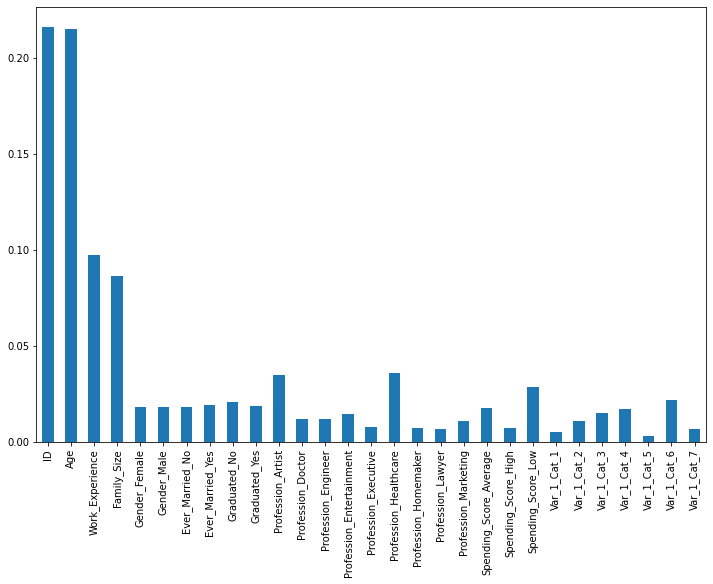

In [233]:
#Random Forest Classifier model using Grid Search CV & Stratified KFold using the best estimator
#------ ------ ---------- ----- ----- ----------- --------------------- ----- --- ---- ---------
i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
print("Creating Model......")
for train_index,cv_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    X_train,X_cv = X.loc[train_index],X.loc[cv_index]
    y_train,y_cv = y[train_index],y[cv_index]  
    model=RandomForestClassifier(random_state=1,max_depth=19,n_estimators=107)
    model.fit(X_train,y_train)
    pred_cv=model.predict(X_cv)
    print("Validation Accuracy : ", accuracy_score(y_cv,pred_cv))
    print()
    i+=1
    
#Prediction in Test Dataset
#---------- -- ---- ------- 
pred_test=model.predict(test)
print("Prediction in Test Data Done successfully")

#Importance of the variables
#---------- -- --- ---------
feature_importances=pd.Series(model.feature_importances_,index=X.columns)
feature_importances.plot.bar(figsize=(12,8))

In [263]:
#XGB Classifier model using Grid Search CV & Stratified KFold
#------ ------ ---------- ----- ----- ----------- ---------------------
#paramgrid= {'max_depth': list(range(1,20,2)),
#            'n_estimators': list(range(1,200,20))}
 


paramgrid= {'max_depth': list(range(12,15,1)),
            'n_estimators': list(range(161,202,5))}
grid_search_XGB=GridSearchCV(XGBClassifier(random_state=1),paramgrid)


X_train,X_cv,y_train,y_cv = train_test_split(X,y,test_size=0.25)k
grid_search_XGB.fit(X_train,y_train)

print("Grid Search Best Parameters:")
print(grid_search_XGB.best_estimator_) 

Grid Search Best Parameters:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=196, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [262]:
print(list(range(161,202,5)))

[161, 166, 171, 176, 181, 186, 191, 196, 201]



Creating Model......

1 of kfold 5
Validation Accuracy :  0.8916744621141254


2 of kfold 5
Validation Accuracy :  0.8884939195509822


3 of kfold 5
Validation Accuracy :  0.8841908325537886


4 of kfold 5
Validation Accuracy :  0.9027128157156221


5 of kfold 5
Validation Accuracy :  0.8907185628742516

Prediction in Test Data Done successfully


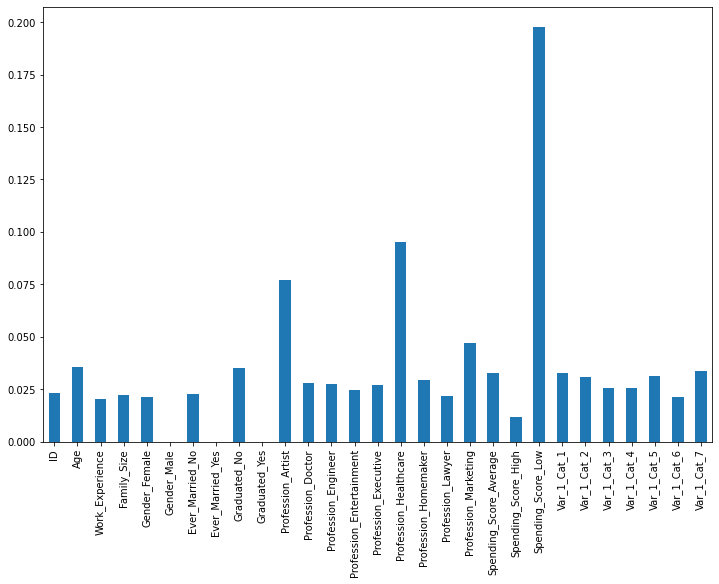

In [264]:
#XG Boost Best Estimator
#-- ----- ---- ---------
from xgboost import XGBClassifier
print()
i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
print("Creating Model......")
for train_index,cv_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    X_train,X_cv = X.loc[train_index],X.loc[cv_index]
    y_train,y_cv = y[train_index],y[cv_index]  
    model=XGBClassifier(random_state=1,max_depth=12,n_estimators=196,objective='multi:softmax',num_class=4,learning_rate=0.1)
    model.fit(X_train,y_train)
    pred_cv=model.predict(X_cv)
    print("Validation Accuracy : ", accuracy_score(y_cv,pred_cv))
    print()
    i+=1

#Prediction in Test Dataset
#---------- -- ---- ------- 
pred_test=model.predict(test)
print("Prediction in Test Data Done successfully")

#Importance of the variables
#---------- -- --- ---------
feature_importances=pd.Series(model.feature_importances_,index=X.columns)
feature_importances.plot.bar(figsize=(12,8))

In [265]:
#Storing the results
#------- --- -------
submission=pd.read_csv('sample_submission_wyi0h0z.csv')
submission['Segmentation']=pred_test
submission['ID']=test_orig['ID']
timestamp=(re.findall('[0-9]+',str(time.time())))[0]
filename='submission_'+str(timestamp)+'.csv'

pd.DataFrame(submission,columns=['ID','Segmentation']).to_csv(filename,index=False)
print("File named {} stored successfully".format(filename))

File named submission_1596361525.csv stored successfully


In [92]:
'''
#Storing the results
#------- --- -------
submission=pd.read_csv('sample_submission_wyi0h0z.csv')
submission['Segmentation']=pred_test
submission['ID']=test_orig['ID']
submission.head(50)

#Creating a Dictionary of Train Data with IDs as Keys and Segmentations as Values
mapped_dict={}
for index, row in test_with_Segmentation.iterrows():
    mapped_dict.update({row['ID'] : row['Segmentation']})

#Copying the Segmentation values into Test Data from Train Data if Test ID matches the Train ID
new_rows=[]
for index,row in submission.iterrows():
  Segmentation_Value=mapped_dict.get(submission['ID'][index])
  if Segmentation_Value!=None:
    submission['Segmentation'][index]=mapped_dict.get(submission['ID'][index])
submission.head()

timestamp=(re.findall('[0-9]+',str(time.time())))[0]
filename='submission_'+str(timestamp)+'.csv'

pd.DataFrame(submission,columns=['ID','Segmentation']).to_csv(filename,index=False)
print("File named {} stored successfully".format(filename))
'''

,ID,Segmentation
0,458989,B
1,458994,C
2,458996,A
3,459000,C
4,459001,C
5,459003,C
6,459005,C
7,459008,B
8,459013,C
9,459014,D
